In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd    
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import json
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
from nltk.tokenize import word_tokenize
import string
from collections import defaultdict, Counter
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import requests
import csv        
from ast import literal_eval
from tqdm import tqdm


%matplotlib inline

plt.style.use('seaborn')
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
os.listdir()

['.config', 'drive', 'sample_data']

In [ ]:
os.chdir('drive/MyDrive')


In [6]:
os.chdir('/content/drive/MyDrive/data (1)') #-> navigate to the folder where your lyrics data are

In [21]:
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
excluded_words = list(set(stopwords_list.decode().splitlines())) + ['na na', 'li' 'yeah', 'ya', 'na', 'dont', 'oh', 'oh oh', 'aint', 'ill', 'ive', 'didnt', 'gon', 'coming', 'gonna', 'wanna', 'thereall', 'thing','EmbedShare','URLCopyEmbedCopy'] + open('profanities.txt', 'r').read().splitlines() 

In [14]:
excluded_words[::-1]

['  "🖕"',
 '  "zoophilia",',
 '  "zoophile",',
 '  "zipperheads",',
 '  "zipperhead",',
 '  "zigabos",',
 '  "zigabo",',
 '  "zabourah",',
 '  "yourtits",',
 '  "yourpenis",',
 '  "yourboobs",',
 '  "yobbo",',
 '  "yiffy",',
 '  "yids",',
 '  "yid",',
 '  "yellowshowers",',
 '  "yellowman",',
 '  "yellow showers",',
 '  "yed",',
 '  "yeasty",',
 '  "yarpies",',
 '  "yarpie",',
 '  "yaoi",',
 '  "yank",',
 '  "xxxxxx",',
 '  "xxx",',
 '  "xx",',
 '  "xtc",',
 '  "xrated",',
 '  "xkwe",',
 '  "x-rated",',
 '  "wuzzie",',
 '  "wuss",',
 '  "wtf",',
 '  "wrinkled starfish",',
 '  "wrapping men",',
 '  "wop",',
 '  "woody",',
 '  "wogs",',
 '  "wog",',
 '  "wn",',
 '  "willy",',
 '  "williewanker",',
 '  "willies",',
 '  "willie",',
 '  "wiggers",',
 '  "wigger",',
 '  "wiggas",',
 '  "wigga",',
 '  "wichser",',
 '  "whoring",',
 '  "whores",',
 '  "whorehouse",',
 '  "whorehopper",',
 '  "whorefucker",',
 '  "whoreface",',
 '  "whored",',
 '  "whorebag",',
 '  "whorealicious",',
 '  "whore

In [10]:
os.listdir()

['Logic.txt',
 'Eminem.txt',
 'Radiohead.txt',
 'Blink-182.txt',
 'Metallica.txt',
 'Iron.txt',
 'Lorde.txt',
 'Pink Floyd.txt',
 'ABBA.txt',
 'Red Hot Chili Peppers.txt',
 'Gorillaz.txt',
 'Tame Impala.txt',
 'Bruce Springsteen.txt',
 'Glass Animals.txt',
 'Iron Maiden.txt',
 'Black Keys.txt',
 'Judas Priest.txt',
 'Coldplay.txt',
 'The Strokes.txt',
 'Oasis.txt',
 'Electric Light Orchestra.txt',
 'Audioslave.txt',
 'Cranberries.txt',
 'Kesha.txt',
 'Linkin Park.txt',
 'The Beatles.txt',
 'our_artistdata.csv',
 'Artists - Songs',
 'doc_tensor.w2v',
 'd2v.model',
 'lyrics_tensor.tsv',
 'lyrics_metadata.tsv',
 'profanities.txt']

In [19]:
def clean_data(lyrics_st):
    lyrics_st = lyrics_st.translate(str.maketrans('', '', string.punctuation)) # removing punctuations
    lyrics_st1 = ' '.join([w for w in lyrics_st.split() if len(w)>2]) # removing words smaller than 3 characters
    lyrics_cleaned  = [word for word in lyrics_st1.split() if word.lower() not in excluded_words] # removing stopwords + my word list + punctuation
    return ' '.join(lyrics_cleaned) # Appending Xi to lyrics

In [16]:
ls

 ABBA.txt                        Kesha.txt
'Artists - Songs'               'Linkin Park.txt'
 Audioslave.txt                  Logic.txt
'Black Keys.txt'                 Lorde.txt
 Blink-182.txt                   lyrics_metadata.tsv
'Bruce Springsteen.txt'          lyrics_tensor.tsv
 Coldplay.txt                    Metallica.txt
 Cranberries.txt                 Oasis.txt
 d2v.model                       our_artistdata.csv
 doc_tensor.w2v                 'Pink Floyd.txt'
'Electric Light Orchestra.txt'   profanities.txt
 Eminem.txt                      Radiohead.txt
'Glass Animals.txt'             'Red Hot Chili Peppers.txt'
 Gorillaz.txt                   'Tame Impala.txt'
'Iron Maiden.txt'               'The Beatles.txt'
 Iron.txt                       'The Strokes.txt'
'Judas Priest.txt'


Logic.txt


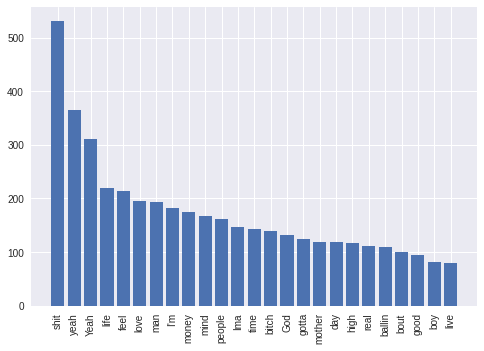

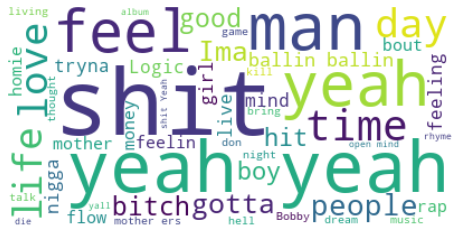

Eminem.txt


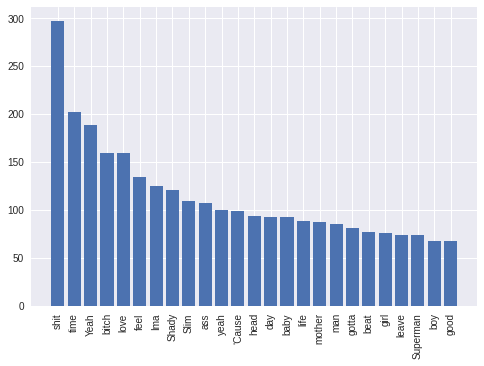

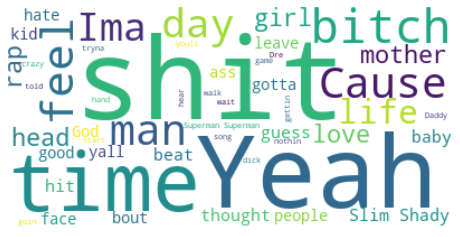

Radiohead.txt


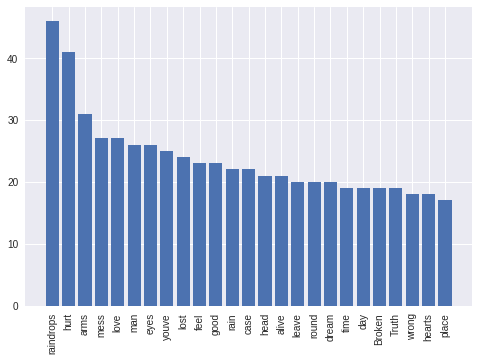

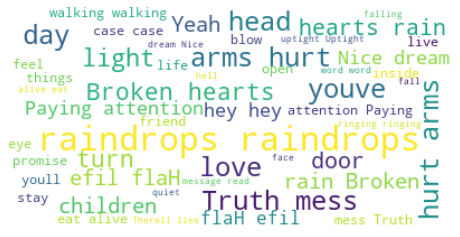

Blink-182.txt


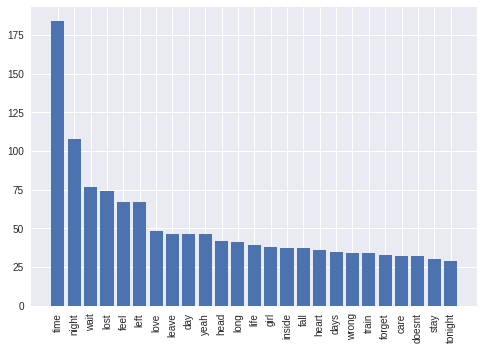

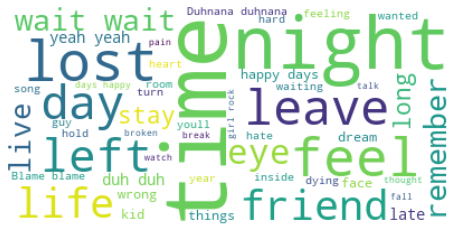

Metallica.txt


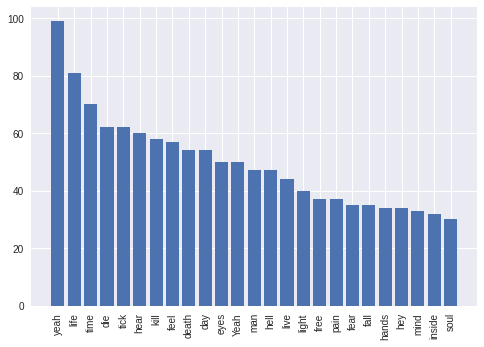

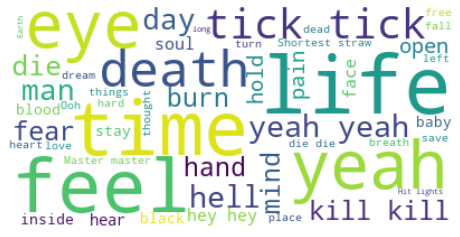

Iron.txt


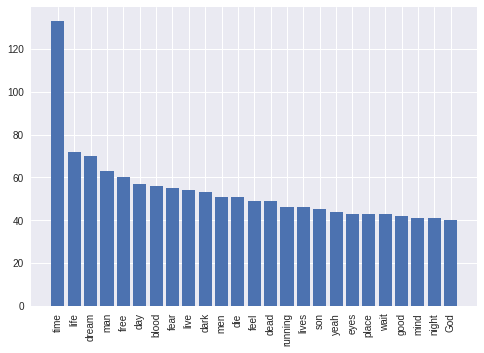

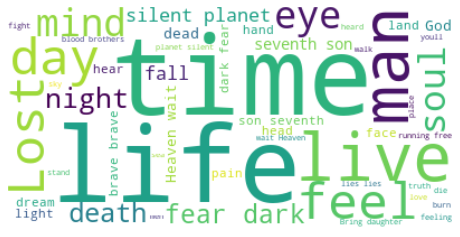

Lorde.txt


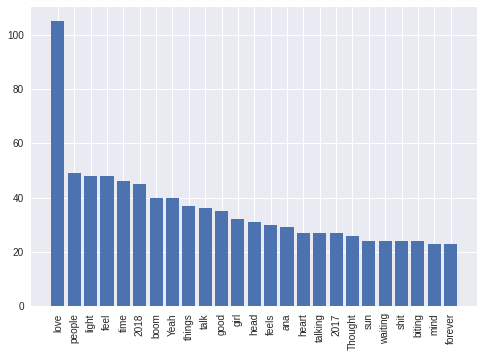

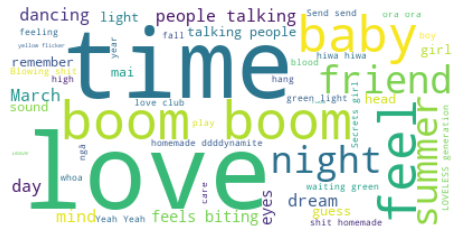

Pink Floyd.txt


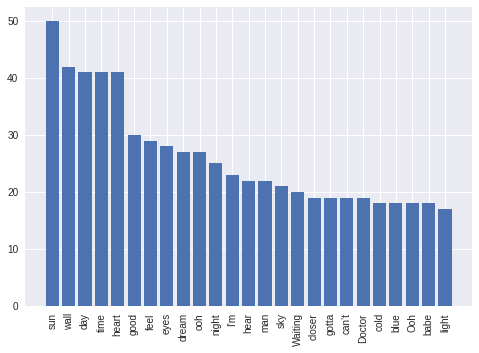

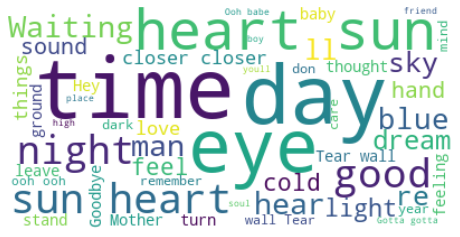

ABBA.txt


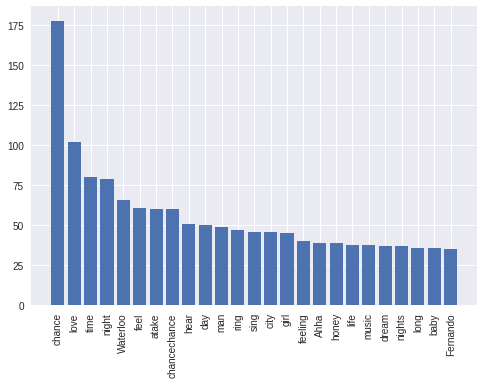

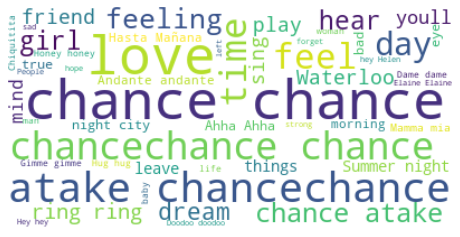

Red Hot Chili Peppers.txt


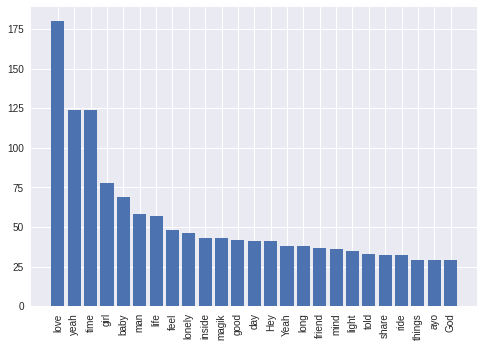

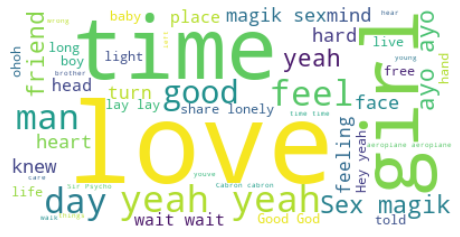

Gorillaz.txt


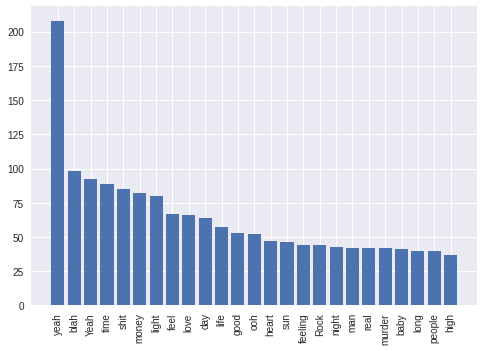

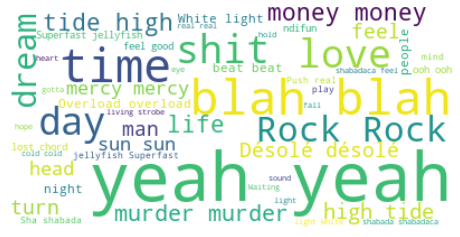

Tame Impala.txt


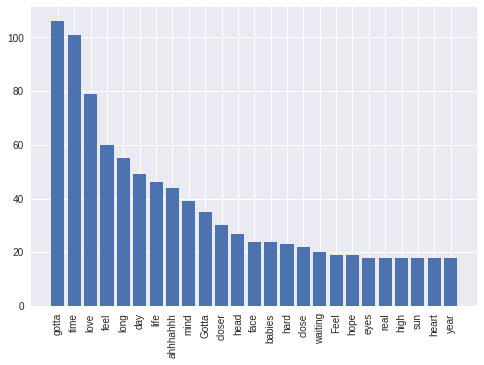

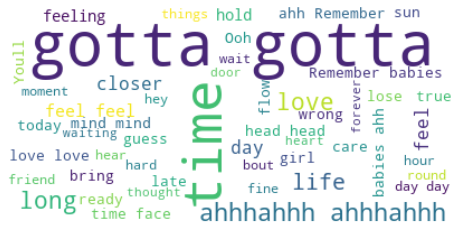

Bruce Springsteen.txt


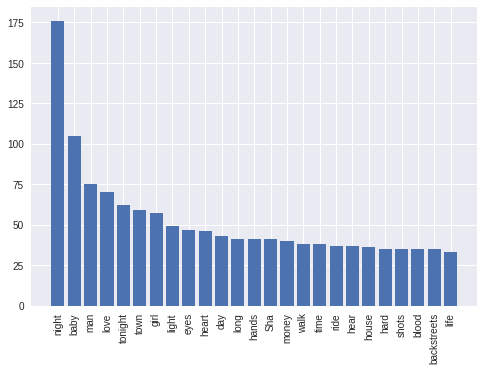

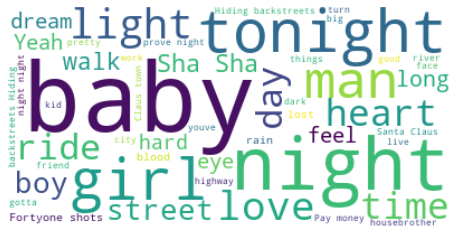

Glass Animals.txt


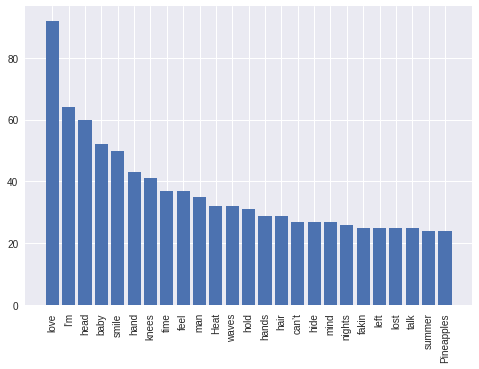

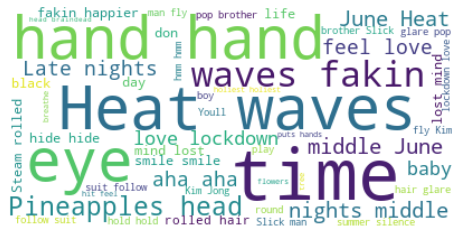

Iron Maiden.txt


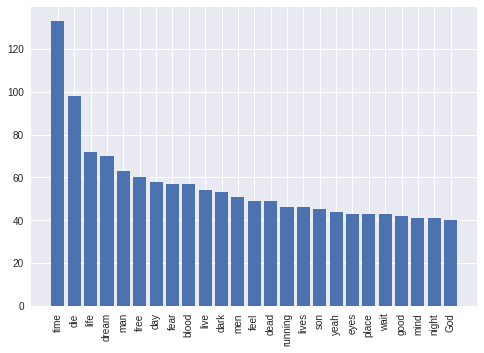

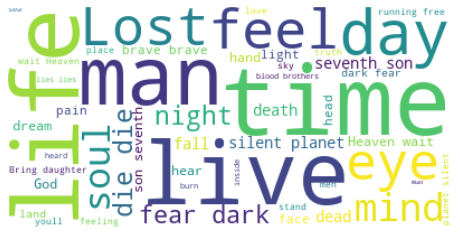

Black Keys.txt


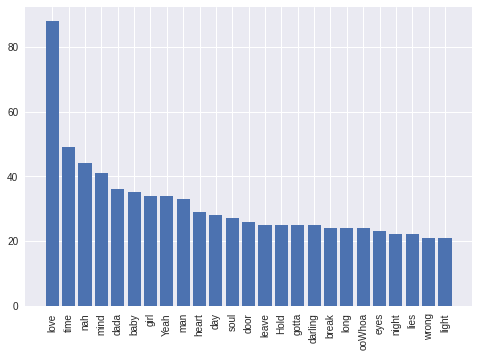

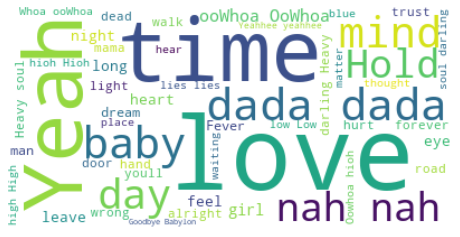

Judas Priest.txt


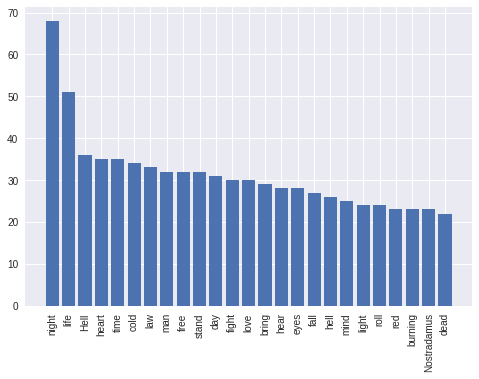

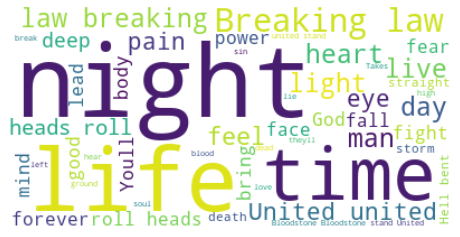

Coldplay.txt


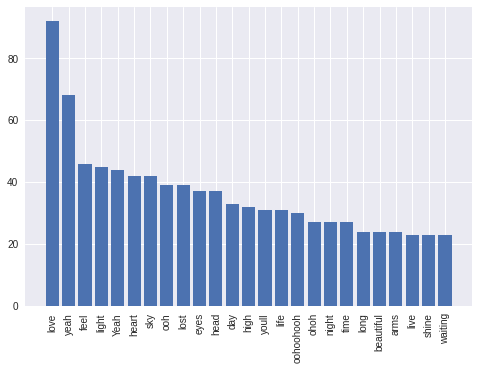

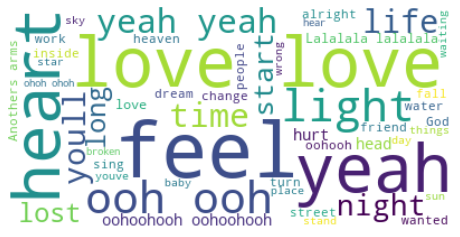

The Strokes.txt


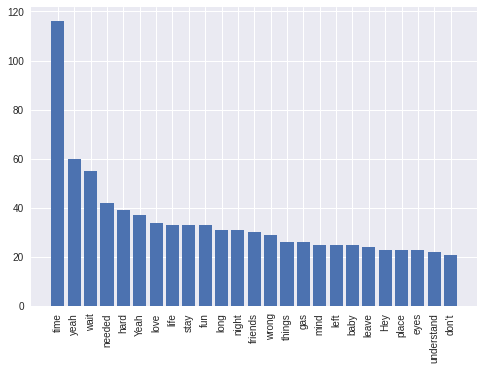

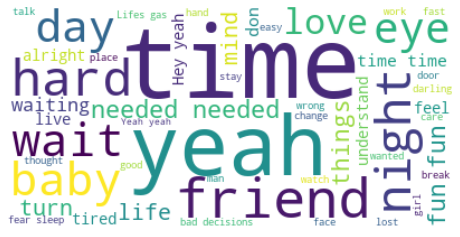

Oasis.txt


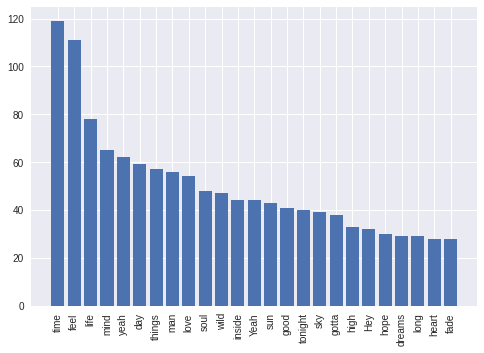

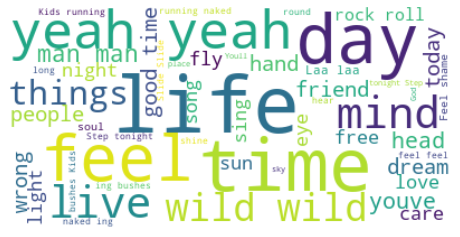

Electric Light Orchestra.txt


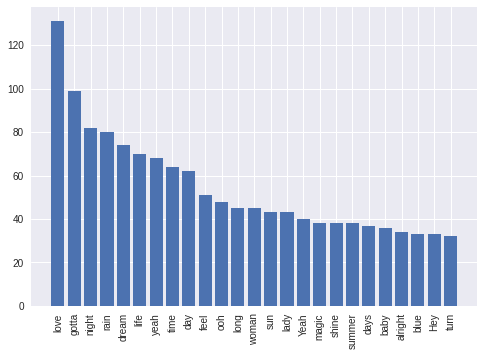

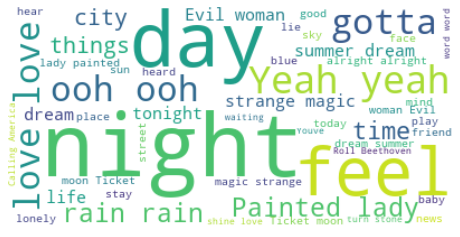

Audioslave.txt


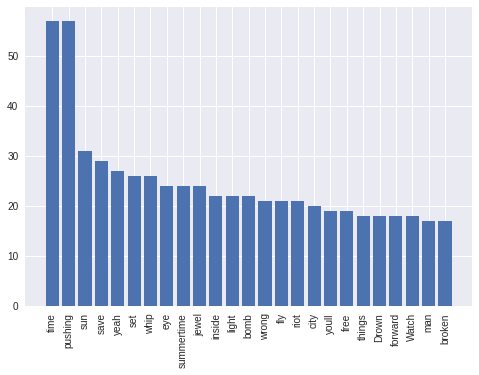

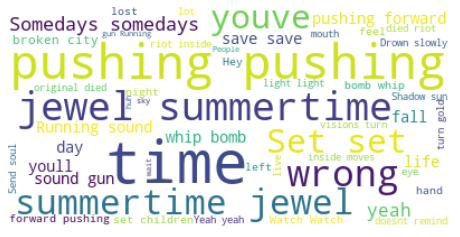

Cranberries.txt


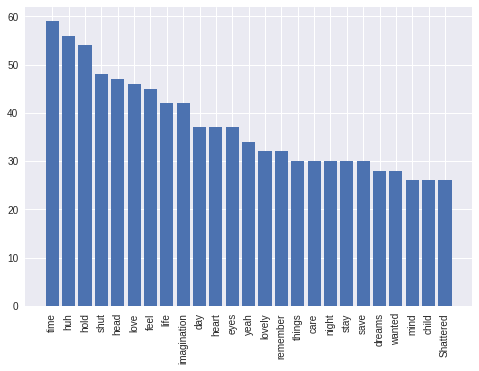

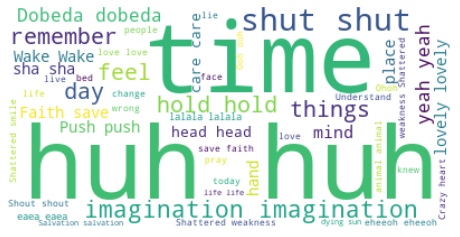

Kesha.txt


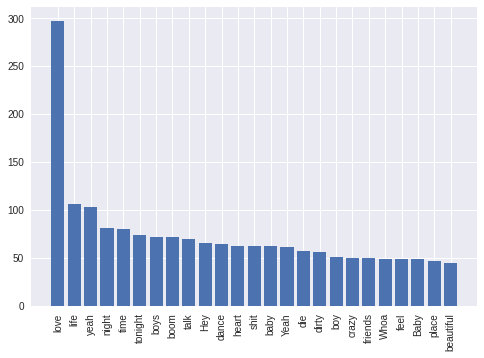

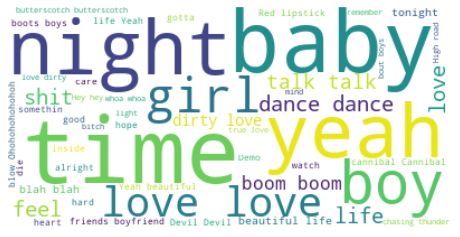

Linkin Park.txt


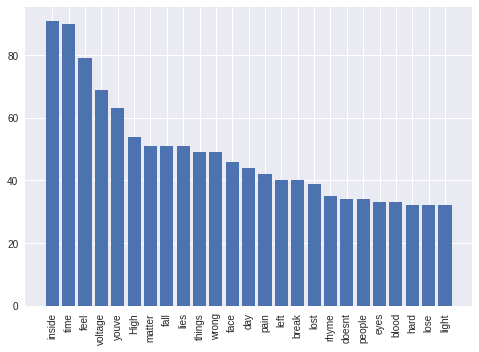

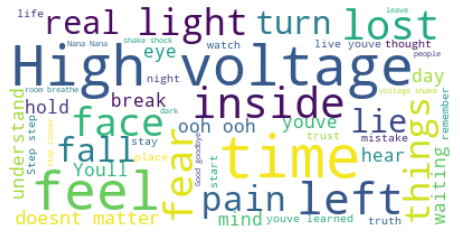

The Beatles.txt


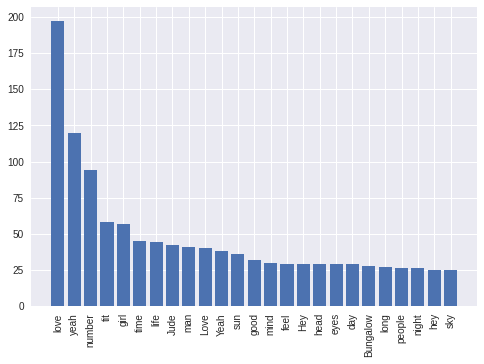

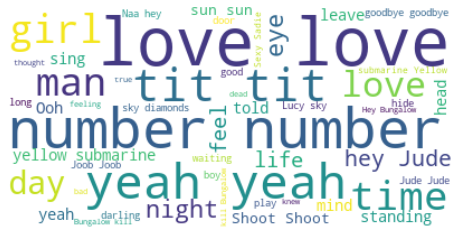

In [24]:
# lyrics contains [X1, X2,...., X9] where Xi -> all the lyrics of one artists
lyrics = []

# artists refers to the name of the artists whose lyrics are in the dataset
artists = []

for i in os.listdir():
    if '.txt' in i and not "profanities" in i:
        artists.append(i.replace('.txt', '').replace('data_', ''))
        print(i)
        
        file = open(i, 'r').read().splitlines() # splitting by line
        lyrics_st = ' '.join(file) # converting into a string
        lyrics_st = lyrics_st.replace("URLCopyEmbedCopy"," ")
        lyrics_st = lyrics_st.replace("fuck"," ")
        lyrics_st = lyrics_st.replace("fuckin"," ").replace("Fuck"," ").replace("Bitch"," ")

        # lyrics_st = lyrics_st.translate(str.maketrans('', '', string.punctuation)) # removing punctuations
        # lyrics_st1 = ' '.join([w for w in lyrics_st.split() if len(w)>2]) # removing words smaller than 3 characters
        # lyrics_cleaned  = [word for word in lyrics_st1.split() if word.lower() not in excluded_words] # removing stopwords + my word list + punctuation
        # lyrics.append(' '.join(lyr)) # Appending Xi to lyrics

        lyrics_cleaned = clean_data(lyrics_st)
        lyrics.append(lyrics_cleaned)

        # top 25 words
        a = Counter(lyrics_cleaned.split()).most_common(25)

        # bar charts for those 25 words
        plt.bar(*zip(*a))
        plt.xticks(rotation=90) # rotating x axis labels
        plt.show()

        wordcloud = WordCloud(max_words=50, background_color='white').generate(lyrics_cleaned)
        plt.imshow(wordcloud, interpolation = 'bilinear')
        plt.axis('off')
        plt.show()
        

In [25]:
tagged_data = [TaggedDocument(words=lyrics[i].split(), tags=str(i)) for i in range(len(lyrics))]

In [26]:
tagged_data

[TaggedDocument(words=['low', 'time', 'feel', 'mind', 'feel', 'life', 'relate', 'Woo', 'low', 'time', 'feel', 'mind', 'feel', 'life', 'alive', 'alive', 'die', 'today', 'die', 'alive', 'alive', 'die', 'shit', 'talkin', 'bout', 'praying', 'save', 'heroic', 'life', 'matter', 'hurting', 'deep', 'place', 'callin', 'phone', 'mind', 'life', 'precious', 'care', 'low', 'time', 'feel', 'mind', 'feel', 'life', 'relate', 'Woo', 'low', 'time', 'feel', 'mind', 'feel', 'life', 'alive', 'alive', 'gotta', 'die', 'today', 'gotta', 'die', 'alive', 'alive', 'gotta', 'die', 'breath', 'heads', 'drowning', 'underwater', 'lightness', 'air', 'chesttochest', 'lover', 'holding', 'roads', 'long', 'light', 'darkest', 'things', 'stare', 'reflection', 'finally', 'knowing', 'youll', 'God', 'goin', 'reason', 'life', 'day', 'night', 'tryna', 'light', 'hard', 'hard', 'gotta', 'live', 'low', 'time', 'feel', 'mind', 'feel', 'life', 'relate', 'Woo', 'low', 'time', 'feel', 'mind', 'feel', 'life', 'finally', 'alive', 'finall

In [ ]:
# Counter(tagged_data[0].words)
# len(tagged_data[0].words)

In [27]:
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in tqdm(range(max_epochs)):
    # print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.epochs)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
model.save_word2vec_format('doc_tensor.w2v', doctag_vec=True, word_vec=False) # we are implementing doc2vec hence doctag_vec parameter will be passed as True and word_vec as False. In case of word2vec, the opposite will be the case.
print("Model Saved")

100%|██████████| 100/100 [03:08<00:00,  1.89s/it]


Model Saved


In [29]:
%run word2vec2tensor.py -i doc_tensor.w2v -o 'lyrics'

<Figure size 576x396 with 0 Axes>

In [30]:
with open('lyrics_metadata.tsv', 'w', newline='') as f_output:
    tsv_output = csv.writer(f_output, delimiter='\n')
    tsv_output.writerow(artists)

In [ ]:
# upload the two generated tsv files to http://projector.tensorflow.org/

In [31]:
model= Doc2Vec.load("d2v.model")
#to find the vector of a document which is not in training data
test_data = word_tokenize("love".lower())
v1 = model.infer_vector(test_data)
print("V1_infer", v1)

# # to find most similar artists using tags
# similar_doc = model.docvecs.most_similar('0')
# print(similar_doc)


# # to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
# print(model.docvecs['1'])

V1_infer [ 0.00564562 -0.01991935 -0.02589334 -0.01326047  0.01391516 -0.02242283
  0.00372444 -0.0066291  -0.01708549  0.00279931 -0.01979817 -0.00527748
 -0.00804158  0.0178069   0.00145533  0.00653379  0.01600325 -0.01749479
 -0.01310431  0.01876039]
